In [3]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from pprint import pformat
import sys

%pip install transforms3d
import transforms3d as t3d
sys.path.append('../')

from hloc import extract_features, match_features, localize_dma, visualization, pairs_from_exhaustive

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
  Using cached https://files.pythonhosted.org/packages/bd/65/915840e94f946e878f3081da6f42c313162d23118bc2e81d7206600eaf00/transforms3d-0.4.1.tar.gz
  Created wheel for transforms3d: filename=transforms3d-0.4.1-cp37-none-any.whl size=1376755 sha256=c0f9b7868e957ac29540029bd419094a8d3f74f780ce5a05b943bedbbb7939e8
  Stored in directory: /Users/qrjuka/Library/Caches/pip/wheels/b4/99/25/0fe95c51c421444ef7a8279c031f86dd62f797e9c1c186128c
Successfully built transforms3d
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Pipeline for indoor localization

## Setup
Here we declare the paths to the dataset, image pairs, and we choose the feature extractor and the matcher. You need to download the [InLoc dataset](https://www.visuallocalization.net/datasets/) and put it in `datasets/inloc/`, or change the path.

In [4]:
data_folder = "grass-lp"

dataset = Path(f'../datasets/kr/{data_folder}/')  # change this if your dataset is somewhere else
images = Path(f'../datasets/kr/{data_folder}/hloc-data')

outputs = Path(f'../datasets/kr/{data_folder}/hloc-data/outputs/')  # where everything will be saved
results = outputs / 'hloc_results.txt'  # the result file

loc_pairs = outputs / 'pairs-query.txt'  # top 40 retrieved by NetVLAD
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

In [5]:
# list the standard configurations available
print(f'Configs for feature extractors:\n{pformat(extract_features.confs)}')
print(f'Configs for feature matchers:\n{pformat(match_features.confs)}')

Configs for feature extractors:
{'d2net-ss': {'model': {'multiscale': False, 'name': 'd2net'},
              'output': 'feats-d2net-ss',
              'preprocessing': {'grayscale': False, 'resize_max': 1600}},
 'dir': {'model': {'name': 'dir'},
         'output': 'global-feats-dir',
         'preprocessing': {'resize_max': 1024}},
 'disk': {'model': {'max_keypoints': 5000, 'name': 'disk'},
          'output': 'feats-disk',
          'preprocessing': {'grayscale': False, 'resize_max': 1600}},
 'netvlad': {'model': {'name': 'netvlad'},
             'output': 'global-feats-netvlad',
             'preprocessing': {'resize_max': 1024}},
 'openibl': {'model': {'name': 'openibl'},
             'output': 'global-feats-openibl',
             'preprocessing': {'resize_max': 1024}},
 'r2d2': {'model': {'max_keypoints': 5000, 'name': 'r2d2'},
          'output': 'feats-r2d2-n5000-r1024',
          'preprocessing': {'grayscale': False, 'resize_max': 1024}},
 'sift': {'model': {'name': 'dog'},
    

In [6]:
# pick one of the configurations for extraction and matching
# you can also simply write your own here!
feature_conf = extract_features.confs['superpoint_inloc']
matcher_conf = match_features.confs['superglue']

## Extract local features for database and query images

In [7]:
#feature_path = extract_features.main(feature_conf, dataset, pairs)
#extract_features.main(feature_conf, images, image_list=references, feature_path=features)
#pairs_from_exhaustive.main(sfm_pairs, image_list=references)
#match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

references = [p.relative_to(images / 'mapping').as_posix() for p in (images / 'mapping/').iterdir() if not '.DS' in str(p)]
print(len(references))
features = extract_features.main(feature_conf, images / 'mapping', 
                      image_list=references, 
                      feature_path=features)
print(features)

[2022/12/28 10:17:38 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 4},
 'output': 'feats-superpoint-n4096-r1600',
 'preprocessing': {'grayscale': True, 'resize_max': 1600}}
[2022/12/28 10:17:38 hloc INFO] Skipping the extraction.


70
../datasets/kr/grass-lp/hloc-data/outputs/features.h5


## Match the query images
Here we assume that the localization pairs are already computed using image retrieval (NetVLAD). To generate new pairs from your own global descriptors, have a look at `hloc/pairs_from_retrieval.py`. These pairs are also used for the localization - see below.

In [8]:
#query_image_path = 'query/DJI_0057.JPG'

queries = [p.relative_to(images / 'query').as_posix() for p in (images / 'query/').iterdir() if not '.DS' in str(p)][:2]

features = extract_features.main(feature_conf, images / 'query', 
                      image_list=queries, 
                      feature_path=features)

pairs_from_exhaustive.main(loc_pairs, image_list=queries, ref_list=references)

#match_path = match_features.main(matcher_conf, loc_pairs, feature_conf['output'], outputs)
print(loc_pairs, features, matches)
match_features.main(matcher_conf, loc_pairs, features=features, matches=matches)

[2022/12/28 10:17:39 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 4},
 'output': 'feats-superpoint-n4096-r1600',
 'preprocessing': {'grayscale': True, 'resize_max': 1600}}
[2022/12/28 10:17:39 hloc INFO] Skipping the extraction.
[2022/12/28 10:17:39 hloc INFO] Found 140 pairs.
[2022/12/28 10:17:39 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
[2022/12/28 10:17:39 hloc INFO] Skipping the matching.


../datasets/kr/grass-lp/hloc-data/outputs/pairs-query.txt ../datasets/kr/grass-lp/hloc-data/outputs/features.h5 ../datasets/kr/grass-lp/hloc-data/outputs/matches.h5


PosixPath('../datasets/kr/grass-lp/hloc-data/outputs/matches.h5')

## Localize!
Perform hierarchical localization using the precomputed retrieval and matches. Different from when localizing with Aachen, here we do not need a 3D SfM model here: the dataset already has 3D lidar scans. The file `InLoc_hloc_superpoint+superglue_netvlad40.txt` will contain the estimated query poses.

In [12]:
localize_dma.main(dataset_dir=dataset, 
                  retrieval=loc_pairs, 
                  images_path=images, 
                  features=features, 
                  matches=matches, 
                  results=results, 
                  skip_matches=20)
        

#localize_dma.main(
#    dataset, loc_pairs, features, matches, results,
#    skip_matches=20)  # skip database images with too few matches

[2022/12/28 10:19:24 hloc INFO] Starting localization...
 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.36it/s]

[-3.89948936  2.62554906 -8.73308298]


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.50it/s]
[2022/12/28 10:19:25 hloc INFO] Writing poses to ../datasets/kr/grass-lp/hloc-data/outputs/hloc_results.txt...
[2022/12/28 10:19:25 hloc INFO] Writing logs to ../datasets/kr/grass-lp/hloc-data/outputs/hloc_results.txt_logs.pkl...
[2022/12/28 10:19:25 hloc INFO] Done!


[-3.94411167  2.96385838 -9.30436398]


## Visualization
We parse the localization logs and for each query image plot matches and inliers with a few database images.

In [31]:
%matplotlib inline
visualization.visualize_loc(results=results, 
                            outputs_dir=outputs / 'plots',
                            image_dir=images / 'query', 
                            db_image_dir=images / 'mapping', 
                            n=len(queries), 
                            show_plots=False,
                            save_plots=True,
                            top_k_db=2, 
                            seed=2)
        
#visualization.visualize_loc(results, images, n=len(queries), top_k_db=1, seed=2)

## Visualize camera poses

altitude=8.5_00241.jpg
[-0.7682579   0.98810981  9.83868296]
altitude=9.2_00840.jpg
[-0.88948896  1.13655667 10.43210001]


<IPython.core.display.Javascript object>


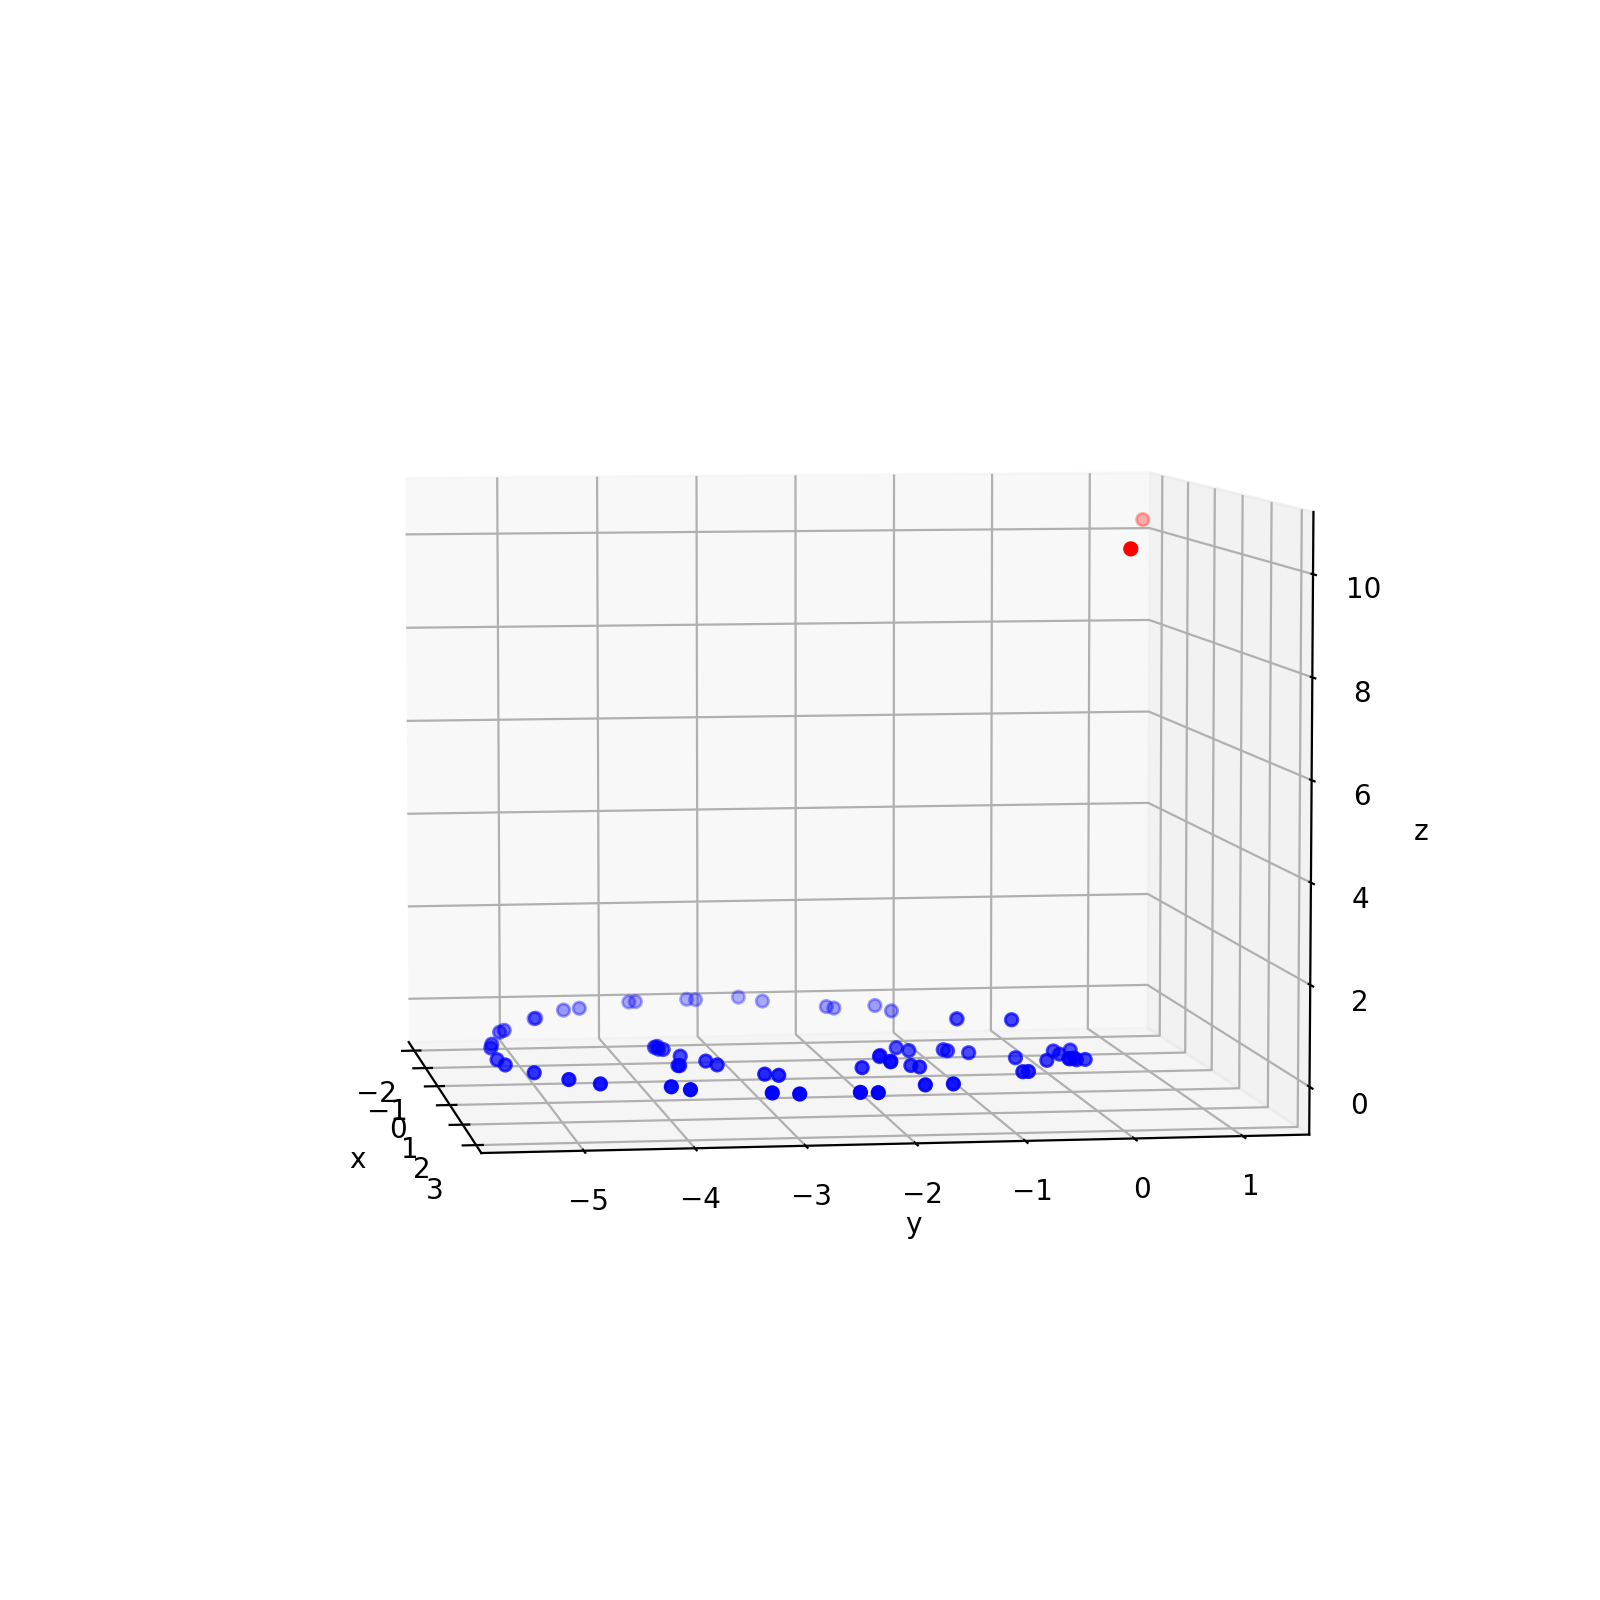

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pyquaternion as pyq
import math

def get_query_camera_poses(result_path):
    query_poses = {}
    with open(result_path) as file:
        q_name = ""
        for line in file:
            line_strip = line.rstrip()
            if line_strip.islower() or line_strip.isupper():
                splitted_line = line_strip.split(" ")
                name = splitted_line[0]
                q_name = name
                img_id = int(os.path.splitext(q_name)[0].split("_")[-1])
                query_poses[img_id] = {}
                query_poses[img_id]["name"] = q_name
                
                # get qvec and tvec
                qvec = [ float(q) for q in splitted_line[1:5]]
                tvec = [ float(v) for v in splitted_line[5:8]]
                
                query_poses[img_id]["qvec"] = qvec
                query_poses[img_id]["tvec"] = tvec
            else:
                Rt = np.zeros((4,4))
                rt = line_strip.split(" ")
                rt = [float(r) for r in rt]
                rt = np.array(rt).reshape((4,4))
                Rt = rt
                #print(Rt)
                query_poses[img_id]["Rt"] = Rt
                query_poses[img_id]["R"] = Rt[:3, :3]
                query_poses[img_id]["t"] = Rt[:3, -1]
    return query_poses

gallery_camera_poses = localize_dma.get_all_camera_poses(images)
query_est_poses = get_query_camera_poses(results)

#print(gallery_camera_poses)

qt, dbt = [], []
Re = []

def getAngle(P, Q):
    R = np.dot(P, Q.T)
    theta = (np.trace(R)-1)/2
    return np.arccos(theta) * (180/np.pi)

for key in gallery_camera_poses.keys():
    db_t = np.array(gallery_camera_poses[key]["translation"])
    db_qvec=gallery_camera_poses[key]["qvec"]
    db_R = np.array(gallery_camera_poses[key]["worldPose"][:3, :3])
    dbt.append(db_t)

for key in query_est_poses.keys():
    #db_t = np.array(gallery_camera_poses[key]["translation"])
    query_t = np.array(query_est_poses[key]["t"])
    q_qvec=query_est_poses[key]["qvec"]
    #db_qvec=gallery_camera_poses[key]["qvec"]
    
    #q1 = pyq.Quaternion(db_qvec)
    #q2 = pyq.Quaternion(q_qvec)
    
    # Get the 3D difference between these two orientations
    #qd = q1.conjugate * q2

    # Calculate Euler angles from this difference quaternion
    #phi   = round(math.atan2( 2 * (qd.w * qd.x + qd.y * qd.z), 1 - 2 * (qd.x**2 + qd.y**2) ), 2)
    #theta = round(math.asin ( 2 * (qd.w * qd.y - qd.z * qd.x) ), 2)
    #psi   = round(math.atan2( 2 * (qd.w * qd.z + qd.x * qd.y), 1 - 2 * (qd.y**2 + qd.z**2) ), 2)
    
    #Re.append([phi, theta, psi])
    
    qt.append(query_t)
    #dbt.append(db_t)

    #db_R = np.array(gallery_camera_poses[key]["worldPose"][:3, :3])
    q_R = np.array(query_est_poses[key]["R"])
    print(query_est_poses[key]["name"])
    print(query_est_poses[key]["t"])
    
    #angle_diff = round(getAngle(db_R, q_R), 3)
    
    #print(f"{key} error, xyz {(np.square(db_t.T- query_t.T))},\n R {angle_diff},\n qvec {phi, theta, psi}\n")
    
    #tx_e.append(x_e)
    #ty_e.append(y_e)
    #tz_e.append(z_e)
    #print(key)
qt = np.array(qt)
dbt = np.array(dbt)
Re = np.array(Re)
#print(f"mse {((dbt - qt)**2).mean(axis=0)} mse euler angles {(Re).mean(axis=0)}")

gal_translations = np.array([gallery_camera_poses[key]["translation"] for key in gallery_camera_poses.keys()])
q_translations = np.array([query_est_poses[key]["t"] for key in query_est_poses.keys()])
#print(gallery_camera_poses)
#print(q_translations)

%matplotlib notebook

gx = gal_translations[:, 0]
gy = gal_translations[:, 1]
gz = gal_translations[:, 2]

qx = q_translations[:, 0]
qy = q_translations[:, 2]
qz = q_translations[:, 1]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.scatter(gx, gz, gy, color="b")
ax.scatter(qx, qz, qy, color="r")
plt.show()


In [ ]:
from hloc.utils.camera_pose_visualizer import CameraPoseVisualizer

%matplotlib notebook

# argument : the minimum/maximum value of x, y, z
keys = np.array(list(gallery_camera_poses.keys()))
print(np.sort(keys))
gal_ext = np.array([gallery_camera_poses[key]["worldPose"] for key in np.sort(keys)])

q_ext = np.array([query_est_poses[key]["Rt"] for key in query_est_poses.keys()])

x_bound = [np.min([ext[0,-1] for ext in gal_ext])-0.5, np.max([ext[0,-1] for ext in gal_ext])+0.5]
y_bound = [np.min([ext[1,-1] for ext in gal_ext])-0.5, np.max([ext[1,-1] for ext in gal_ext])+0.5]
z_bound = [np.min([ext[2,-1] for ext in gal_ext])-0.5, np.max([ext[2,-1] for ext in gal_ext])+0.5]

visualizer = CameraPoseVisualizer(x_bound, z_bound, y_bound)

# argument : extrinsic matrix, color, scaled focal length(z-axis length of frame body of camera
for ext in gal_ext:
    print(ext)
    ty = ext[1,-1]
    tz=ext[2,-1]
    ext[1,-1]=tz
    ext[2,-1]=ty
#     flip_YZ = np.eye(4)
#     flip_YZ[1,1] = -1
#     flip_YZ[2,2] = -1
#     ext = ext @ flip_YZ
    visualizer.extrinsic2pyramid(ext, 'c', 0.2, 0.4)
    
print("\nQUERY POSES:")
for ext in q_ext:
    print(ext)
    ty = ext[1,-1]
    tz=ext[2,-1]
    ext[1,-1]=tz
    ext[2,-1]=ty
#     flip_YZ = np.eye(4)
#     flip_YZ[1,1] = -1
#     flip_YZ[2,2] = -1
#     ext = ext @ flip_YZ
    visualizer.extrinsic2pyramid(ext, 'r', 0.2, 0.3)
#print(np.eye(4))
#visualizer.extrinsic2pyramid(gal_ext[0], 'c', 10)
visualizer.show()

In [ ]:
from platform import python_version

print(python_version())

In [ ]:
# argument : extrinsic matrix, color, scaled focal length(z-axis length of frame body of camera
for ext in gal_ext:
    
    
print("\nQUERY POSES:")
for ext in q_ext:
    